# House prices

Kairos (April 2018)

## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

# Logistic Regression
* Reframe the SalePrice value predictor (from the preceding exercises) as a binary classification model
* Compare the effectiveness of logisitic regression vs linear regression for a binary classification problem

As in the prior exercises, we're working with the Iowa housing data set, but this time we will turn it into a binary classification problem by predicting whether a house is a high-cost city house. We'll also revert to the default features, for now.

## Frame the Problem as Binary Classification

The target of our dataset is `SalePrice` which is a numeric (continuous-valued) feature. We can create a boolean label by applying a threshold to this continuous value.

Given features describing a house, we wish to predict if it is a high-cost house. To prepare the targets for train and eval data, we define a classification threshold of the 75%-ile for SalePrice value (a value of approximately 215000). All house values above the threshold are labeled `1`, and all others are labeled `0`.

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2. Load our data set
Next, we'll load our data set and show information about it.

In [2]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices_train.csv", sep=",")
housing_dataframe.shape
housing_dataframe.describe()
housing_dataframe.info()
housing_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,2,0,1,0,0,0,0,0,0,1
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1447,1457,20,13175,6,6,1978,1988,119.0,790,163,...,1,0,2,0,0,1,1,0,0,0
1448,1458,70,9042,7,9,1941,2006,0.0,275,0,...,5,0,0,0,0,0,0,0,0,0
1449,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,1,0,1,0,2,0,0,0,0,0


In [3]:
# Create a synthetic feature.
# Create a new category for total habitable surface
housing_dataframe["habitableSF"] = housing_dataframe["1stFlrSF"] + housing_dataframe["2ndFlrSF"] + housing_dataframe["GrLivArea"]
#housing_dataframe['SQMeter_price'] = housing_dataframe.apply(lambda row: row['SalePrice'] / row['habitableSF'], axis=1)
housing_dataframe['SQMeter_price'] = 0  

Note how the code below is slightly different from the previous exercises. Instead of using `SalePrice` as target, we create a new binary target, `SalePrice_value_is_high`.

In [4]:
def preprocess_features(housing_dataframe):
  """Prepares input features from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = housing_dataframe[
    ["YearRemodAdd",
     "BedroomAbvGr",
     "OverallCond"]]
  processed_features = selected_features.copy()
  
 
  # Create a new synthetic feature
  processed_features['SQMeter_price'] = ( 
    housing_dataframe['SalePrice'] / 
    housing_dataframe['habitableSF'])

  return processed_features

def preprocess_targets(housing_dataframe):
  """Prepares target features (i.e., labels) from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # SalePrice is above a set threshold.
  output_targets["SalePrice_value_is_high"] = (
    housing_dataframe["SalePrice"] > 215000).astype(float)
  return output_targets

## 3. Splitting

In [5]:
# Choose the first 1000 (out of 1451) examples for training.
training_examples = preprocess_features(housing_dataframe.head(1000))
training_targets = preprocess_targets(housing_dataframe.head(1000))

# Choose the last 500 (out of 1451) examples for validation.
validation_examples = preprocess_features(housing_dataframe.tail(500))
validation_targets = preprocess_targets(housing_dataframe.tail(500))

# Double-check that we've done the right thing.
print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

Training examples summary:


,YearRemodAdd,BedroomAbvGr,OverallCond,SQMeter_price
count,1000.0,1000.0,1000.0,1000.0
mean,1985.1,2.9,5.6,60.8
std,20.4,0.8,1.1,15.5
min,1950.0,0.0,1.0,15.2
25%,1967.0,2.0,5.0,50.7
50%,1994.0,3.0,5.0,60.2
75%,2004.0,3.0,6.0,69.3
max,2010.0,8.0,9.0,138.1


Validation examples summary:


,YearRemodAdd,BedroomAbvGr,OverallCond,SQMeter_price
count,500.0,500.0,500.0,500.0
mean,1983.8,2.9,5.6,59.3
std,21.2,0.8,1.1,15.7
min,1950.0,0.0,3.0,14.2
25%,1964.8,2.0,5.0,49.0
50%,1992.0,3.0,5.0,59.2
75%,2004.0,3.0,6.0,68.9
max,2010.0,6.0,9.0,118.8


Training targets summary:


,SalePrice_value_is_high
count,1000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,SalePrice_value_is_high
count,500.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


## How Would Linear Regression Fare?
To see why logistic regression is effective, let us first train a naive model that uses linear regression. This model will use labels with values in the set `{0, 1}` and will try to predict a continuous value that is as close as possible to `0` or `1`. Furthermore, we wish to interpret the output as a probability, so it would be ideal if the output will be within the range `(0, 1)`. We would then apply a threshold of `0.5` to determine the label.

Run the cells below to train the linear regression model using [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor).

In [6]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [31]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of one feature.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float` specifying the learning rate.
    steps: A non-zero `int` specifying the total number of training steps. A training step
      consists of both a forward and backward pass using a single batch.
    batch_size: A non-zero `int` specifying the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  
 # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 1: Can We Calculate LogLoss for These Predictions?

**Examine the predictions and decide whether or not we can use them to calculate LogLoss.**

`LinearRegressor` uses the L2 loss, which doesn't do a great job at penalizing misclassifications when the output is interpreted as a probability.  For example, there should be a huge difference whether a negative example is classified as positive with a probability of 0.9 vs 0.9999, but L2 loss doesn't strongly differentiate these cases.

In contrast, `LogLoss` penalizes these "confidence errors" much more heavily.  Remember, `LogLoss` is defined as:

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


But first, we'll need to obtain the prediction values. We could use `LinearRegressor.predict` to obtain these.

Given the predictions and that targets, can we calculate `LogLoss`?

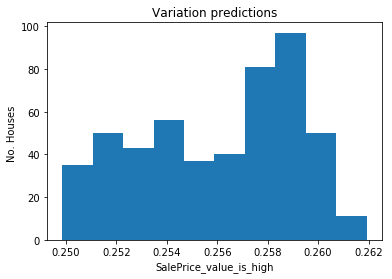

In [21]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["SalePrice_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

plt.ylabel("No. Houses ")
plt.xlabel("SalePrice_value_is_high")
plt.title("Variation predictions")
_ = plt.hist(validation_predictions)

## Task 2: Train a Logistic Regression Model and Calculate LogLoss on the Validation Set

To use logistic regression, simply use [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) instead of `LinearRegressor`. Complete the code below.

**NOTE**: When running `train()` and `predict()` on a `LinearClassifier` model, you can access the real-valued predicted probabilities via the `"probabilities"` key in the returned dict—e.g., `predictions["probabilities"]`. Sklearn's [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) function is handy for calculating LogLoss using these probabilities.


In [23]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "LogLoss (on training data):"
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_log_loss)
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print "Model training finished."
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier



Training model...
LogLoss (on training data):
  period 00 : 0.55
  period 01 : 0.53
  period 02 : 0.52
  period 03 : 0.51
  period 04 : 0.51
  period 05 : 0.50
  period 06 : 0.49
  period 07 : 0.49
  period 08 : 0.49
  period 09 : 0.48
Model training finished.


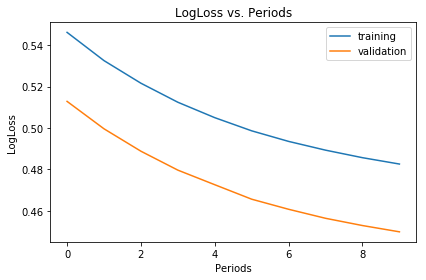

In [28]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000001,
    steps=20000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 3: Calculate Accuracy and plot a ROC Curve for the Validation Set

A few of the metrics useful for classification are the model [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the area under the ROC curve (AUC). We'll examine these metrics.

`LinearClassifier.evaluate` calculates useful metrics like accuracy and AUC.

In [29]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']

AUC on the validation set: 0.77
Accuracy on the validation set: 0.81


You may use class probabilities, such as those calculated by LinearClassifier.predict, and Sklearn's roc_curve to obtain the true positive and false positive rates needed to plot a ROC curve.

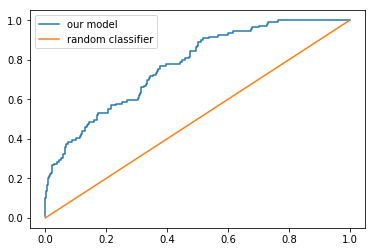

In [30]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

See if you can tune the learning settings of the model trained at Task 2 to improve AUC.

Often times, certain metrics improve at the detriment of others, and you'll need to find the settings that achieve a good compromise.

Verify if all metrics improve at the same time.

One possible solution that works is to just train for longer, as long as we don't overfit.

We can do this by increasing the number the steps, the batch size, or both.

All metrics improve at the same time, so our loss metric is a good proxy for both AUC and accuracy.

Notice how it takes many, many more iterations just to squeeze a few more units of AUC. This commonly happens. But often even this small gain is worth the costs.

Training model...
LogLoss (on training data):
  period 00 : 0.54
  period 01 : 0.52
  period 02 : 0.50
  period 03 : 0.49
  period 04 : 0.48
  period 05 : 0.47
  period 06 : 0.47
  period 07 : 0.47
  period 08 : 0.47
  period 09 : 0.47
Model training finished.


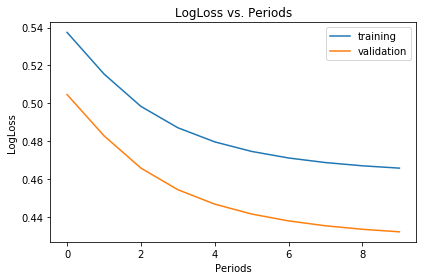

In [34]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000001,
    steps=20000,
    batch_size=1000,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)